# **NOTEBOOK:** bucket_fico
## **Author:** Data Scientist, Jaime Orejarena
## **Purpose:** Create FICO buckets using MSE quantization and Log-Likelihood DP
## **Requirements:** pandas, numpy, matplotlib, scikit-learn

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Config / paths
DATA_PATH = 'Task 3 and 4_Loan_Data.csv'  
OUTPUT_DIR = r"C:/Users/Usuario/Documents/GitHub/JPMorgan-Chase---Co/TASK 4 - Bucket FICO scores/Bucket_FICO_scores/fico_bucket_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# Load data
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Data shape: (10000, 8)
Columns: ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [4]:
# Quick datatype/missingness summary
display(df.info())
display(df.describe().T)
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


None

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,4.974577e+06,2.293890e+06,1.000324e+06,2.977661e+06,4.989502e+06,6.967210e+06,8.999789e+06
credit_lines_outstanding,10000.0,1.461200e+00,1.743846e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
loan_amt_outstanding,10000.0,4.159677e+03,1.421399e+03,4.678397e+01,3.154235e+03,4.052377e+03,5.052898e+03,1.075068e+04
total_debt_outstanding,10000.0,8.718917e+03,6.627165e+03,3.165273e+01,4.199836e+03,6.732407e+03,1.127226e+04,4.368878e+04
income,10000.0,7.003990e+04,2.007221e+04,1.000000e+03,5.653987e+04,7.008583e+04,8.342917e+04,1.484122e+05
years_employed,10000.0,4.552800e+00,1.566862e+00,0.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,1.000000e+01
fico_score,10000.0,6.375577e+02,6.065791e+01,4.080000e+02,5.970000e+02,6.380000e+02,6.790000e+02,8.500000e+02
default,10000.0,1.851000e-01,3.883981e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

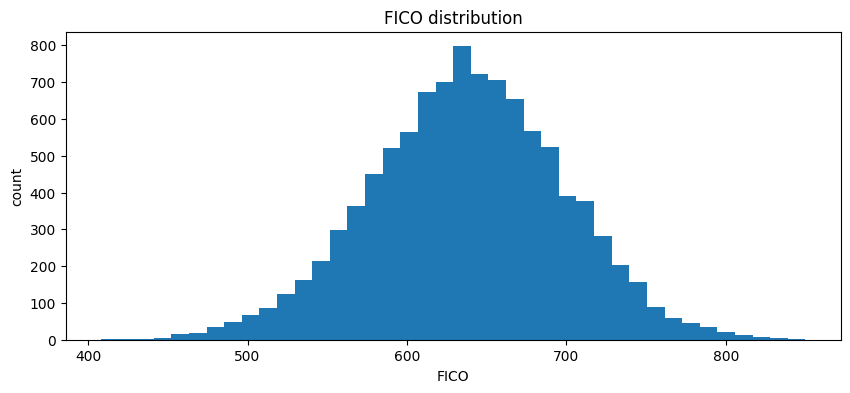

In [5]:
# EDA: distribution & PD by coarse bins
# -------------------------
plt.figure(figsize=(10,4))
plt.hist(df['fico_score'], bins=40)
plt.title("FICO distribution")
plt.xlabel("FICO")
plt.ylabel("count")
plt.show()

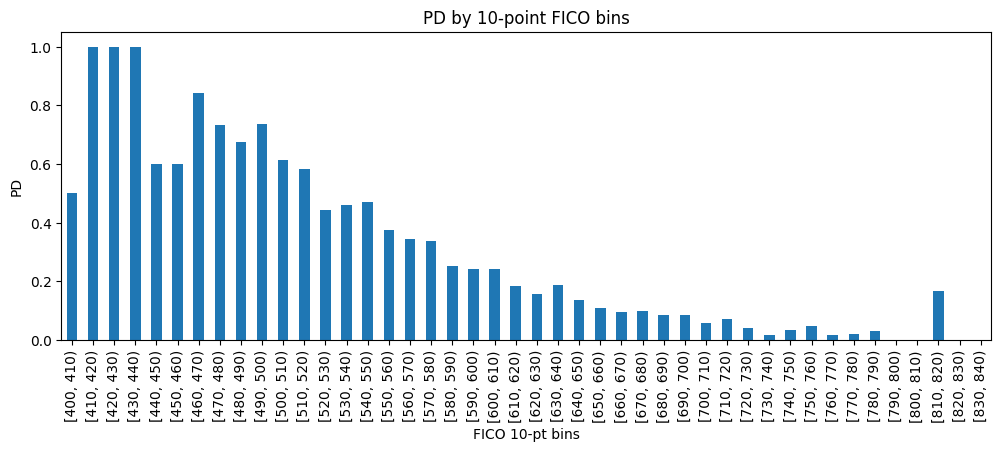

In [6]:
# Coarse bins PD (10-point FICO bins)
df['fico_10bin'] = pd.cut(df['fico_score'], bins=np.arange(300, 855, 10), right=False)
pd_by_bin = df.groupby('fico_10bin')['default'].agg(['mean', 'count'])
pd_by_bin = pd_by_bin[pd_by_bin['count']>0]
pd_by_bin['mean'].plot(kind='bar', figsize=(12,4), title='PD by 10-point FICO bins')
plt.xlabel('FICO 10-pt bins')
plt.ylabel('PD')
plt.show()

In [7]:
# Prepare sorted arrays for DP
# -------------------------
# We'll sort observations by FICO. DP will consider splitting by index.
df_sorted = df.sort_values(by='fico_score').reset_index(drop=True)
x = df_sorted['fico_score'].values
y = df_sorted['default'].values
n = len(x)
print(f"Records for DP: {n}")

Records for DP: 10000


In [8]:
# For DP we can compress identical FICO values to aggregated counts (this speeds up DP).
agg = df_sorted.groupby('fico_score')['default'].agg(['count', 'sum']).reset_index().sort_values(by='fico_score')
agg = agg.rename(columns={'count':'n','sum':'k'})
agg['p'] = agg['k']/agg['n']
print("Unique FICO levels:", agg.shape[0])

fico_vals = agg['fico_score'].values
counts = agg['n'].values
defaults = agg['k'].values

Unique FICO levels: 374
